# MAC0318 - Arquiteturas sensorimotoras - Notebook 2

*Pré-requisitos*: 
- **Software**: Para rodar este notebook corretamente, você deve ter o Python na versão 3.9 ou mais recente e as bibliotecas NumPy e OpenCV. Antes de começar, assegure-se de que essas condições são satisfeitas.
- **Conhecimento**: Esta atividade assume familiaridade com o uso de notebooks Jupyter, a manipulação de matrizes usando a bilbioteca NumPy e a representação de imagens digitais coloridas em matrizes. Recomendamos seguir algum tutorial da internet antes de realizar essa ativdade, se esse não for o seu caso.
- **Compreensão** do filtro de segmentação por cor, realizado no [notebook anterior](ArquiteturasSensorimotoras01.ipynb).

<span style="color:blue">Se você está rodando o notebook em sala de aula, você deve ativar o ambiente `duckietown` do conda antes de abrir o jupyter notebook e escolher o kernel `duckietown`, para que os requerimentos sejam satisfeitos.</red>

## Veículo de Braitenberg

Nessa atividade você vai implementar um agente com arquiquetura sensorimotora seguindo a abordagem dos veículos de Braitenberg e assumindo que as fontes atratoras são patos, como na figura abaixo.

<figure>
  <div style="text-align: center">
  <img src="img/muitospatos.jpeg" alt="Muitos patos!" width="300">
  </div>
</figure>

Seu robô deve adotar o comportamento "enamorado" (_lover_):

> O veículo se aproxima da fonte com velocidade inversamente proporcional à distância, 
> evitando colisão com a fonte (ou seja, parando quando próximo).

Isso é feito usando a conexão sensorimotora exibida na figura abaixo:

<figure>
  <div style="text-align: center">
  <img src="img/lover.png" alt="Comportamento enamorado" width="200">
  </div>
</figure>

## Implementando os sensores de fonte de luz a partir da câmera


O sensor principal (e o único que usaremos nessa atividade) do robô duckiebot é a câmera digital frontal.

<figure>
  <div style="text-align: center">
  <img src="img/duckiebot.jpg" alt="Duckiebot" width="300">
  </div>
</figure>

Uma câmera digital é apenas uma coleção de sensores de luz organizados matricialmente.
Dada a forma matricial da imagem, vamos representar as conexões entre sensores e atuadores também como uma matriz de pesos +1 ou -1, 
indicando uma relação (conexão) *estimulante* ou *inibitória*, respectivamente.
Ademais, vamos preprocessar a imagem usando o filtro de segmentação de cores para identificar apenas a presença da cor amarela na imagem,
que será nossa fonte de estímulo.

## Sensor de patos

Mais especificamente, vamos usar obter uma matriz $`M\in\{0,1\}^{m\times n}`$ representando uma 
máscara da imagem capturada pela câmera tal que
```math
M_{ij}=\begin{cases}
  1&\text{ se o pixel }(i,j)\text{ é da cor dos patos,}\\
  0&\text{ caso contrário.}
\end{cases}
```
Os valores $`m`$ e $`n`$ definem a largura e altura das imagens capturadas pela câmera do robô.

In [1]:
# Vamos primeiro carregar os módulo necessários
# para mostrar imagens no notebook:
%matplotlib inline 
from pylab import imshow
from matplotlib import pyplot as plt
# para maninpulação de matrizes (numpy):
import numpy as np
from numpy import uint8
# e para manipulação de imagens (opencv):
import cv2

In [4]:
# Intervalo para pontos amarelados (H em [5,30]) 
lower_hsv = np.array([5, 100, 100])    
upper_hsv = np.array([30, 255, 255])
# Imagem de exemplo
image = cv2.imread('img/pato1.jpeg') # devolve vetor multidimensional do numpy 
image = image[:,:,::-1] # Transforma canais BGR em RGB

# Construir máscara dos pontos no hiperretângulo do espaço HSV especificado
hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
mask = cv2.inRange(hsv, lower_hsv, upper_hsv)//255;

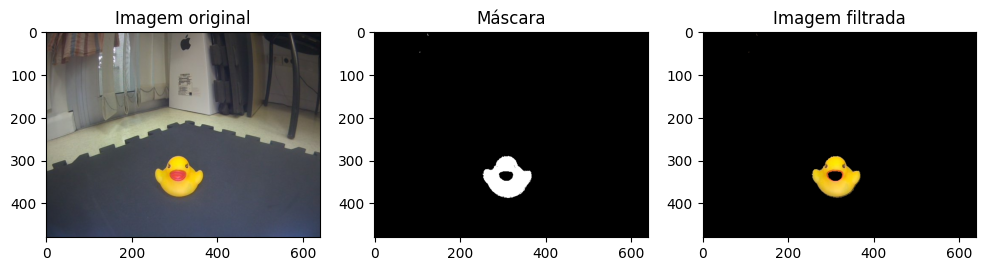

In [5]:
# Aplicar máscara na imagem (representada em RGB)
masked = cv2.bitwise_and(image[:,:,:3], image[:,:,:3], mask=mask)
f, ax = plt.subplots(1,3, figsize=(12,5))
ax[0].imshow(image);
ax[0].set_title('Imagem original');
ax[1].imshow(mask, cmap='gray');
ax[1].set_title('Máscara');
ax[2].imshow(masked[:,:,:3]);
ax[2].set_title('Imagem filtrada');

## Conexões com os motores

Para implementar o comportamento de um veículo de Braitenberg, precisamos especificar as conexões entre sensores (pixels da máscara da imagem) e atuadores (sinais para os motores esquerdo e direito).
Faremos isso definindo as matrizes de pesos de conexão $`L\in\mathbb{R}^{m \times n}`$ e $`R\in\mathbb{R}^{m \times n}`$.
O elemento $`L_{i,j}`$, por exemplo, especifica o tipo de conexão entre o sensor relativo ao pixel em $`(i,j)`$ e o motor esquerdo.
Esse elemento será +1 para uma conexão estimulante, -1 para uma conexão inibitória e 0 para ausênsica ("fio desconectado").

O sinal enviado a cada motor é obtido pela média de todas as conexões, usando uma relação linear.
Motor esquerdo:
```math
p_l = c + g \cdot\frac{1}{z}\left(\sum_{i=1}^n\sum_{j=1}^m L_{ij}\cdot M_{ij} \right),
```
Motor direito:
```math
p_r = c + g \cdot\frac{1}{z}\left(\sum_{i=1}^n\sum_{j=1}^m R_{ij}\cdot M_{ij} \right) .
```

No protocolo implementado, os valores $`p_l`$ e $`p_r`$ determinam a tensão elétrica enviada aos motores e devem estar no intervalo $`[-1,1]`$, com valores positivos movendo a roda em um sentido e valores negativos na sentido contrário. A constante $`c`$ faz com que o robô se mova na ausência de estímulo e o ganho $`g`$ determina a velocidade em relação ao estímulo médio dado pelo produto ponto-a-ponto das matrizes de conexão e da máscara da imagem. A constante $`z`$ serve para normalizar os valores para que a soma não cresça demais.

Note que diferentes comportamentos podem ser obtidos alterando apenas as matrizes de conexão.


In [36]:
# Vamos criar matrizes L e R de dimensão iguais as da imagem da câmera
L = np.zeros(shape=(image.shape[0],image.shape[1]), dtype="float32")
R = np.zeros(shape=(image.shape[0],image.shape[1]), dtype="float32")

In [37]:
# Vamos definir conexões inibitórias ligando a parte esquerda da imagem ao motor esquerdo:
L[:, :image.shape[1]//2] = -1   # -1 'inibe' ação, +1 'estimula' e 0 ignora
# e a parte direita da imagem ao motor direito:
R[:, image.shape[1]//2:] = -1

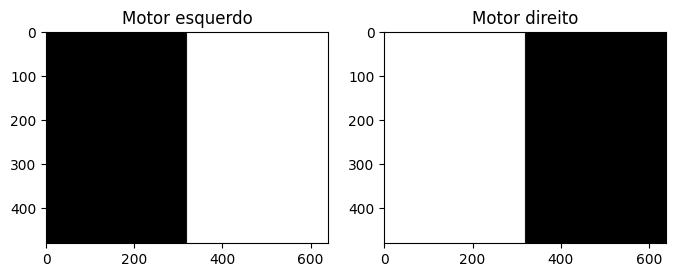

In [38]:
# Vamos visualizar as matrizes de conexões como imagens
f, ax = plt.subplots(1,2, figsize=(8,5))
ax[0].imshow((L-L.min())/(L.max()-L.min()), cmap='gray'); # precisamos transformar matriz para [0,1] para exibí-la como imagem
ax[0].set_title('Motor esquerdo');
ax[1].imshow((R-R.min())/(R.max()-R.min()), cmap='gray');
ax[1].set_title('Motor direito');

Vamos calcular os sinais enviados aos motores como:
```python
pwm_left  = const + gain *  np.sum( L * M ) 
pwm_right = const + gain *  np.sum( R * M ) 
```

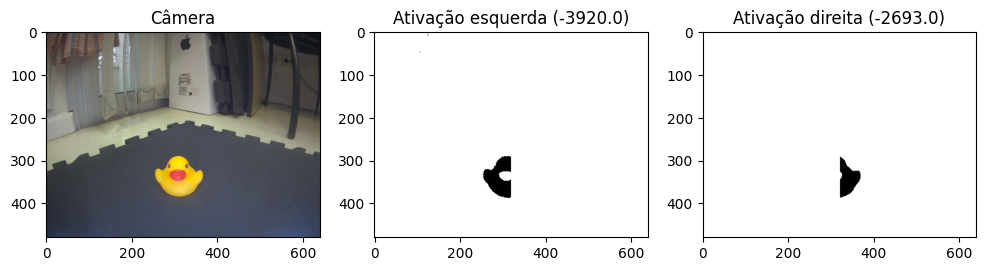

In [39]:
Lmean = np.sum(L * mask)
Rmean = np.sum(R * mask)
f, ax = plt.subplots(1,3, figsize=(12,5))
ax[0].imshow(image); 
ax[0].set_title('Câmera');
ax[1].imshow(L * mask, cmap='gray'); # precisamos transformar matriz para [0,1] para exibí-la como imagem
ax[1].set_title(f'Ativação esquerda ({Lmean})');
ax[2].imshow(R * mask, cmap='gray');
ax[2].set_title(f'Ativação direita ({Rmean})');

Como mencionado antes, os valores dos sinais enviados aos motores devem estar no intervalo $`[-1,1]`$.
Para facilitiar a escolha das constantes, vamos redimensionar os valores médios de ativação esquerda e direita (exibidos nos títulos dos gráficos acima), para os intervalo unitário.

In [10]:
def rescale(x: float, L: float, U: float):
    ''' Redimensionsa scalar x in interval [L, U] to interval [0, 1]. '''
    return (x - L) / (U - L)

In [55]:
# Vamos usar como limite superior 1/4 da área da imagem, e como limite inferior seu negativo
# Melhores valores podem ser encontrados analisando as imagens obtidas pelo robô
limit = image.shape[0] * image.shape[1]/4
Lmean = rescale(np.sum(L * mask), -limit, limit)
Rmean = rescale(np.sum(R * mask), -limit, limit)
# Valores médios normalizados
print(f'np.sum(L*M) = {Lmean}')
print(f'np.sum(R*M) = {Rmean}')

np.sum(L*M) = 0.4744791666666667
np.sum(R*M) = 0.4824674479166667


Para implementar o comportamento enamorado, você precisa definir as constantes `const` e `gain` adequadamente.
A constante `const` define a velocidade do robô na ausência de estímulo.
Ela é portanto dependente da interação do robô com o piso. 

Já a constante `gain` define a redução da velocidade em função do aumento do estímulo. Uma boa heurística é considerar o caso em que gostaríamos de ter o robô parado.
Modifique os valores dessas constantes abaixo, para que o robô envie valores próximo a zero (ou levemente negativos) quando observa uma imagem de um pato muito próximo, mas valores razoavelmenten altos quando o pato está distante.

In [54]:
# Vamos definir algumas funções auxiliares primeiro
def preprocess(image: np.ndarray) -> np.ndarray:
        'Devolve máscara de filtro de segmentação por cores'
        hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        mask = cv2.inRange(hsv, lower_hsv, upper_hsv)//255
        return mask

def show_controller(image, const, gain):
    P = preprocess(image)
    Lmean = rescale(np.sum(P*L), 0, limit)
    Rmean = rescale(np.sum(P*R), 0, limit)
    pwm_left = const + gain*Lmean
    pwm_right = const + gain*Rmean
    f, ax = plt.subplots(1,3, figsize=(10,3))
    ax[0].imshow(image); 
    ax[0].set_title('Câmera');
    ax[1].imshow(L * P, cmap='gray'); # precisamos transformar matriz para [0,1] para exibí-la como imagem
    ax[1].set_title(f'Motor esquerdo ({pwm_left:.4f})');
    ax[2].imshow(R * P, cmap='gray');
    ax[2].set_title(f'Motor direito ({pwm_right:.4f})');    

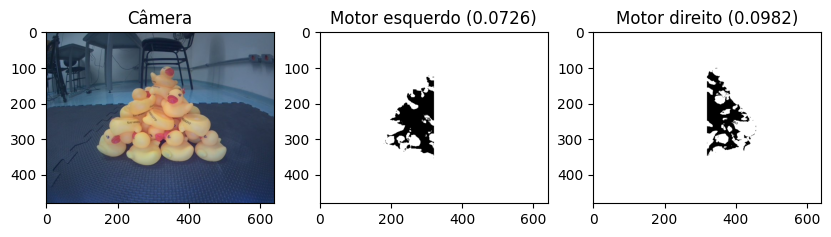

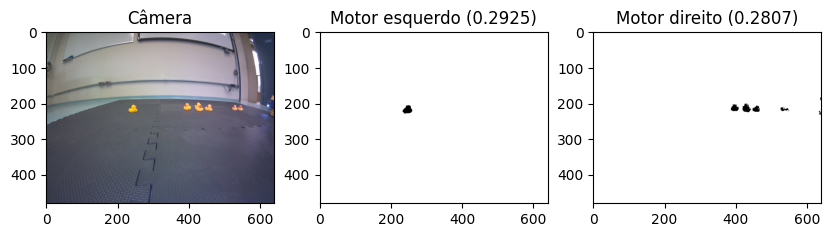

In [66]:
# Modifique as constantes abaixo para que os sinais enviados sejam < 0.1 
# na primeira imagem e > 0.2 na segunda imagem
const, gain = 0.3, 1.3

image_perto = cv2.imread('img/piramide_perto.jpeg')
image_perto = image_perto[:,:,::-1] # Transforma canais BGR em RGB
show_controller(image_perto, const, gain)
image_longe = cv2.imread('img/patolonge.jpeg')
image_longe = image_longe[:,:,::-1] # Transforma canais BGR em RGB
show_controller(image_longe, const, gain)

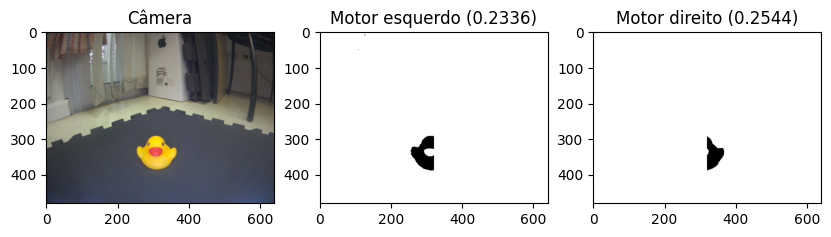

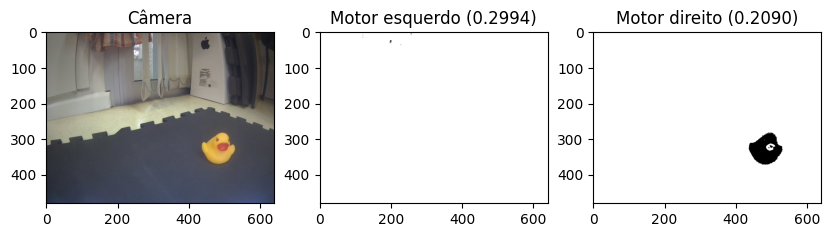

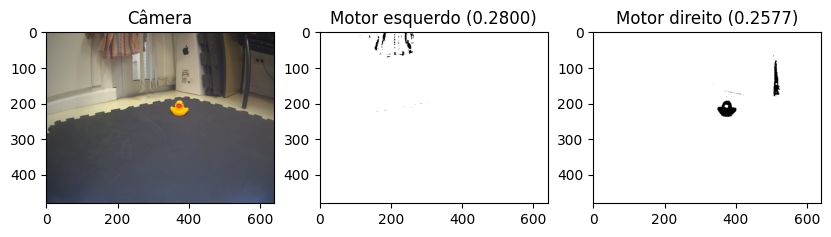

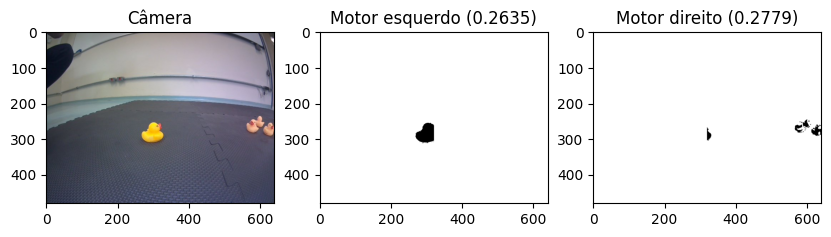

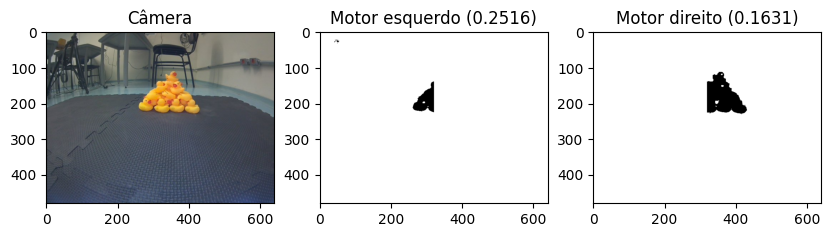

In [67]:
# Agora observe o comportamento em outras imagens/condições

dirname = 'img'
filenames = ['pato1.jpeg', 'pato2.jpeg', 'pato3.jpeg', 'patomedio.jpeg', 'piramide_longe.jpeg']
for filename in filenames:
    image = cv2.imread(f'{dirname}/{filename}') 
    image = image[:,:,::-1] # Transforma canais BGR em RGB
    show_controller(image, const, gain)